In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import numpy as np

data = fetch_openml('mnist_784', version=1)#Get data from https://www.openml.org/d/554
dfData = pd.DataFrame(np.c_[data["data"],data["target"]],columns = data["feature_names"]+["target"]).astype(int)
dfData = dfData.iloc[:2000]
stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in stratSplit.split(dfData[data["feature_names"]], dfData["target"]):
    X_train = dfData[data["feature_names"]].iloc[train_index].values
    X_test = dfData[data["feature_names"]].iloc[test_index].values
    
    y_train = dfData["target"].iloc[train_index].values
    y_test = dfData["target"].iloc[test_index].values

In [2]:
from sklearn.cluster import KMeans
n_clusters = 50
km = KMeans(n_clusters=n_clusters,
            random_state=0,
            n_jobs=2
           )
km.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=50, n_init=10, n_jobs=2, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [3]:
def findClosetsDatapoint(X_train, cluster_center):
    dists = X_train - cluster_center
    distnp = np.sum(np.power(dists,2),axis=1)
    return np.argmin(distnp)
inds = []
for i in range(len(km.cluster_centers_)):
    inds.append(findClosetsDatapoint(X_train, km.cluster_centers_[i]))

In [4]:
clusters = X_train[inds].copy()
labels = y_train[inds].copy()

X_train = np.delete(X_train, inds, axis=0) # remove data points we have labeled
y_train = np.delete(y_train, inds) # remove data points we have labeled

true_labels = np.append(labels, y_train[:1000])
clusters = np.append(clusters,X_train[:1000]) # add extra deta for label propagation, can use more but that makes it
                                              # take longer to run
clusters = clusters.reshape(-1, 784) # update shape to be proper MNIST shape
labels = np.append(labels,-1*np.ones(1000)) # add -1 labels for instances where labels are unknown

In [5]:
from sklearn.semi_supervised import LabelPropagation
label_prop = LabelPropagation(kernel='knn', # 'rbf'
                       gamma=20,
                       n_neighbors=7,
                       max_iter=1000,
                       tol=0.001,
                       n_jobs=2
                      )
label_prop.fit(clusters, labels)
newLabels = label_prop.predict(clusters)

/Users/maxschallwig/opt/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/Users/maxschallwig/opt/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=1000 was reached without convergence.
  category=ConvergenceWarning


In [6]:
print(label_prop.label_distributions_.shape) # label matrix (n_samples, n_classes)
print(label_prop.transduction_.shape) # labels assigned to each item

(1050, 10)
(1050,)


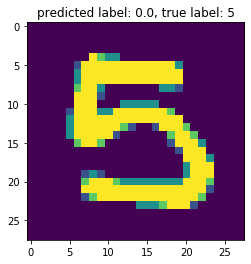

In [7]:
index = n_clusters
plt.imshow(clusters[index].reshape(28,28))
plt.title(f'predicted label: {newLabels[index]}, true label: {true_labels[index]}')
plt.show()
# look at confusion matrix or predict_proba outputs to identify cases where the model is uncertain in or often making 
# mistakes, add in extra manual labels for these problem cases

In [8]:
from sklearn.metrics import accuracy_score
accuracy_score(true_labels,newLabels)

0.08666666666666667

In [9]:
from sklearn.semi_supervised import LabelSpreading
label_spread = LabelSpreading(kernel='knn', # 'rbf'
                             gamma=20,
                             n_neighbors=7,
                             alpha=0.2, # clamping, 20% of label distribution can be changed
                             max_iter=30,
                             tol=0.001,
                             n_jobs=2
                            )
label_spread.fit(clusters, labels)
newLabels = label_spread.predict(clusters)

In [10]:
print(label_spread.label_distributions_.shape) # label matrix (n_samples, n_classes)
print(label_spread.transduction_.shape) # labels assigned to each item

(1050, 10)
(1050,)


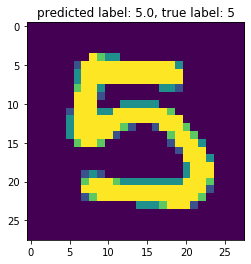

0.8066666666666666

In [11]:
index = n_clusters
plt.imshow(clusters[index].reshape(28,28))
plt.title(f'predicted label: {newLabels[index]}, true label: {true_labels[index]}')
plt.show()
accuracy_score(true_labels,newLabels)

In [12]:
from sklearn.svm import SVC

svc_rbf = SVC()
svc_rbf.fit(clusters[:n_clusters],labels[:n_clusters])
svc_rbf.score(clusters,true_labels)

0.6114285714285714

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(clusters[:n_clusters],labels[:n_clusters])
knn_clf.score(clusters,true_labels)

0.6638095238095238